# Iris univariate joint probability distribution 

Again, it's the Iris dataset (I promise I will unleash some 'real' datasets at some point). I've done a lot of bivariate cluster plots, so I wanted to put together a 1d probability distribution based upon a custom query.

In this instance, it's purely plotting the joint probability distribution of each of the variables given the class, e.g. P(sepal_length|iris_class), P(petal_length|iris_class) ... and so on.

In [4]:
%matplotlib inline
import pandas as pd
import sys
sys.path.append("../../../bayespy")
import bayespy
from bayespy.network import Builder as builder

import logging
import os
import math
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

bayespy.jni.attach(logger)

db_folder = bayespy.utils.get_path_to_parent_dir("")
iris = pd.read_csv(os.path.join(db_folder, "data/iris.csv"), index_col=False)

def plot(ax, head_variables, results):
    for i, hv in enumerate(head_variables):
        x = np.arange(iris[hv].min()-2, iris[hv].max()+2, 0.05)
        pdfs = [ss.norm.pdf(x, results[k]['mean'], math.sqrt(results[k]['variance'])) for k, v in results.items()]
        density = np.sum(np.array(pdfs), axis=0)
        ax.plot(x, density, label='Joint pdf')
        ax.set_ylabel("pdf")
        for k, v in results.items():
            sns.distplot(iris[iris.iris_class == k][hv], hist=False, label=k, ax=ax)



Create the network, specifying a latent variable.

In [5]:
network = bayespy.network.create_network()
cluster = builder.create_cluster_variable(network, 4)
node = builder.create_multivariate_continuous_node(network, iris.drop('iris_class',axis=1).columns.tolist(), "joint")
builder.create_link(network, cluster, node)

class_variable = builder.create_discrete_variable(network, iris, 'iris_class', iris['iris_class'].unique())
builder.create_link(network, cluster, class_variable)

And finally, query the model, specifying each variable in a separate query (otherwise the query will return a covariance matrix)

INFO:root:Writing 150 rows to storage
Writing 150 rows to storage
Writing 150 rows to storage
INFO:root:Finished writing 150 rows to storage
Finished writing 150 rows to storage
Finished writing 150 rows to storage
INFO:root:Training model...
Training model...
Training model...
INFO:root:Finished training model
Finished training model
Finished training model
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


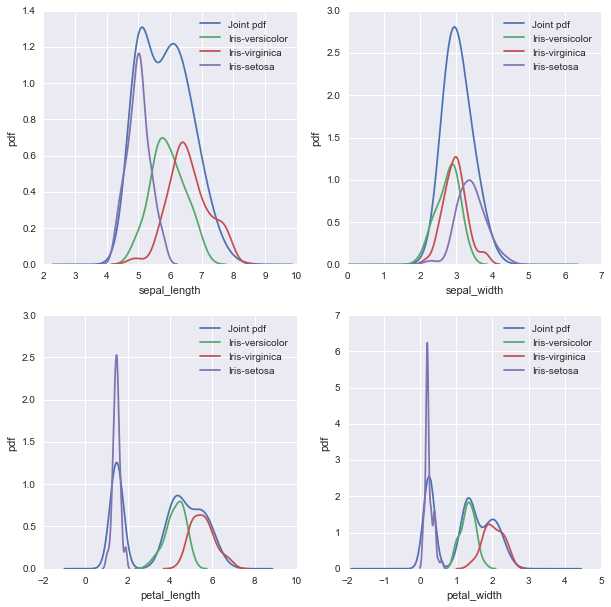

In [6]:
head_variables = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

with bayespy.data.DataSet(iris, db_folder, logger) as dataset:
    model = bayespy.model.NetworkModel(network, logger)
    model.train(dataset)

    queries = [bayespy.model.QueryMixtureOfGaussians(
                   head_variables=[v],
                    tail_variables=['iris_class']) for v in head_variables]

    (engine, _, _) = bayespy.model.InferenceEngine(network).create()
    query = bayespy.model.SingleQuery(network, engine, logger)
    results = query.query(queries)
    fig = plt.figure(figsize=(10,10))
    for i, r in enumerate(results):
        ax = fig.add_subplot(2, 2, i+1)
        plot(ax, queries[i]._head_variables, r)

    plt.show()